In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.individual as individual
import multitask.models.parallel as parallel
import multitask.models.task_switching as task_switching
from multitask.representations import get_mean_activations, calculate_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs


In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#a1c9f4ff', '#ffaaa8ff', '#8ce4a0ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_rsa_all = os.path.join('svg', 'figureS08b_rsa_models.svg')
path_model_individual = os.path.join('..', '..', 'results', 'individual')
path_model_parallel = os.path.join('..', '..', 'results', 'parallel')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value', 'prime', 'fibonacci', 'multiples3']
idxs_contexts = [0, 1, 2, 3, 4]

## RSA Models

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}
data_folder_task_switching = check_runs(path_model_task_switching, parameters)

parameters['idxs_contexts'] = None
data_folder_individual = check_runs(path_model_individual, parameters)
data_folder_parallel = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_18_27)
Found simulation in ../../results/individual with the same parameters (2022-09-27_22_43_07)
Found simulation in ../../results/parallel with the same parameters (2022-09-28_00_08_35)


In [6]:
pickle_data_individual = os.path.join(data_folder_individual, 'data.pickle')
with open(pickle_data_individual, 'rb') as handle:
    results_individual = pickle.load(handle)

pickle_data_parallel = os.path.join(data_folder_parallel, 'data.pickle')
with open(pickle_data_parallel, 'rb') as handle:
    results_parallel = pickle.load(handle)

pickle_data_task_switching = os.path.join(data_folder_task_switching, 'data.pickle')
with open(pickle_data_task_switching, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)
device = get_device()
criterion = nn.CrossEntropyLoss()

Running on CPU.


In [8]:
# Individual
seeds_individuals = sorted(list(results_individual.keys()))
num_seeds = len(seeds_individuals)
num_layers = len(num_hidden)
list_rdm_individual = []

for i_seed, seed in tqdm(enumerate(seeds_individuals), total=num_seeds):
    task_activations = []
    task_numbers = []

    indices = results_individual[seed]['indices']

    for i_task, task_name in enumerate(tasks_names):
        state_dict = results_individual[seed][task_name]['model']

        model = individual.get_individual_model(num_hidden,
                                                device)
        model.load_state_dict(state_dict)
        
        task_dataset = tasks_datasets[task_name]
        test_sampler = dataset.SequentialSampler(indices['test'])
        testloader = torch.utils.data.DataLoader(task_dataset,
                                                 sampler=test_sampler,
                                                 batch_size=batch_size)

        numbers = testloader.dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        _, activations = individual.hooks.get_layer_activations(model,
                                                                testloader,
                                                                criterion,
                                                                device=device,
                                                                disable=True)
        
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)

    list_rdm_individual.append(rdm_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# parallel
seeds_parallel = sorted(list(results_parallel.keys()))
num_tasks = len(tasks_names)
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks_datasets[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)
list_rdm_parallel = []

for i_seed, seed in tqdm(enumerate(seeds_parallel), total=num_runs):
    state_dict = results_parallel[seed]['model']
    model = parallel.get_parallel_model(num_tasks,
                               num_hidden,
                               device)

    model.load_state_dict(state_dict)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    numbers = parallel_datasets[tasks_names[0]].numbers.numpy()
    numbers = numbers[indices['test']]
    
    _, activations = parallel.hooks.get_layer_activations(model,
                                                 parallel_testloader,
                                                 criterion=criterion,
                                                 device=device,
                                                 disable=True)

    task_activations = []
    task_numbers = []
    
    for task_name in tasks_names:
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)

    list_rdm_parallel.append(rdm_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0, 0, 0, 0]
value: [0, 1, 0, 0, 0]
prime: [0, 0, 1, 0, 0]
fibonacci: [0, 0, 0, 1, 0]
multiples3: [0, 0, 0, 0, 1]


In [11]:
seeds_task_swithing  = sorted(list(results_task_switching.keys()))
list_rdm_task_switching = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = task_switching.get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = task_switching.hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)

    list_rdm_task_switching.append(rdm_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
def calculate_rsa(first_rdm_list, second_rdm_list):
    assert len(first_rdm_list) == len(second_rdm_list)
    num_seeds = len(first_rdm_list)

    assert first_rdm_list[0].keys() == second_rdm_list[0].keys()
    num_layers = len(first_rdm_list[0].keys())
    rsa_matrix = np.zeros((num_seeds, num_layers))

    for i_seed in range(num_seeds):
        for i_layer in range(num_layers):
            first_rdm = first_rdm_list[i_seed][i_layer+1].flatten()
            second_rdm = second_rdm_list[i_seed][i_layer+1].flatten()
            rsa_matrix[i_seed, i_layer] = np.corrcoef(first_rdm, second_rdm)[0, 1]
    return rsa_matrix


def calculate_rsa_diagonal(first_rdm_list, second_rdm_list):
    assert len(first_rdm_list) == len(second_rdm_list)
    num_seeds = len(first_rdm_list)

    assert first_rdm_list[0].keys() == second_rdm_list[0].keys()
    num_layers = len(first_rdm_list[0].keys())
    rsa_matrix = np.zeros((num_seeds, num_layers))

    for i_seed in range(num_seeds):
        for i_layer in range(num_layers):
            first_rdm = np.concatenate((first_rdm_list[i_seed][i_layer+1][:10, :10].flatten(),
                                        first_rdm_list[i_seed][i_layer+1][10:, 10:].flatten()))
            second_rdm = np.concatenate((second_rdm_list[i_seed][i_layer+1][:10, :10].flatten(),
                                        second_rdm_list[i_seed][i_layer+1][10:, 10:].flatten()))
            rsa_matrix[i_seed, i_layer] = np.corrcoef(first_rdm, second_rdm)[0, 1]
    return rsa_matrix

def calculate_rsa_off_diagonal(first_rdm_list, second_rdm_list):
    assert len(first_rdm_list) == len(second_rdm_list)
    num_seeds = len(first_rdm_list)

    assert first_rdm_list[0].keys() == second_rdm_list[0].keys()
    num_layers = len(first_rdm_list[0].keys())
    rsa_matrix = np.zeros((num_seeds, num_layers))

    for i_seed in range(num_seeds):
        for i_layer in range(num_layers):
            first_rdm = np.concatenate((first_rdm_list[i_seed][i_layer+1][:10, 10:].flatten(),
                                        first_rdm_list[i_seed][i_layer+1][10:, :10].flatten()))
            second_rdm = np.concatenate((second_rdm_list[i_seed][i_layer+1][:10, 10:].flatten(),
                                        second_rdm_list[i_seed][i_layer+1][10:, :10].flatten()))
            rsa_matrix[i_seed, i_layer] = np.corrcoef(first_rdm, second_rdm)[0, 1]
    return rsa_matrix

In [13]:
rsa_individual_parallel = calculate_rsa(list_rdm_individual,
                                        list_rdm_parallel)

mean_rsa_individual_parallel = rsa_individual_parallel.mean(axis=0)
std_rsa_individual_parallel = rsa_individual_parallel.std(axis=0)

rsa_individual_task_switching = calculate_rsa(list_rdm_individual,
                                              list_rdm_task_switching)

mean_rsa_individual_task_switching = rsa_individual_task_switching.mean(axis=0)
std_rsa_individual_task_switching = rsa_individual_task_switching.std(axis=0)

rsa_parallel_task_switching = calculate_rsa(list_rdm_parallel,
                                            list_rdm_task_switching)

mean_rsa_parallel_task_switching = rsa_parallel_task_switching.mean(axis=0)
std_rsa_parallel_task_switching = rsa_parallel_task_switching.std(axis=0)

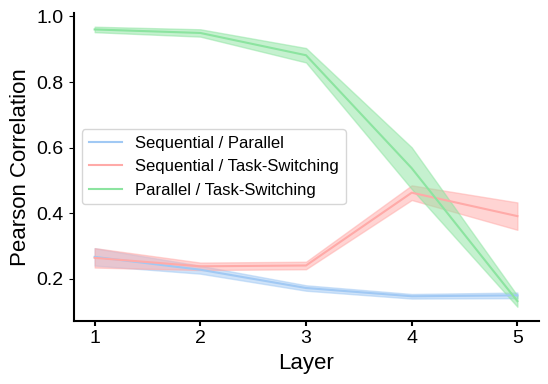

In [14]:
layers = range(1, num_layers + 1)
fig = plt.figure(figsize=(6, 4))

plt.plot(layers, mean_rsa_individual_parallel, color=palette[0])
plt.plot(layers, mean_rsa_individual_task_switching, color=palette[1])
plt.plot(layers, mean_rsa_parallel_task_switching, color=palette[2])

plt.fill_between(layers,
                 mean_rsa_individual_parallel-std_rsa_individual_parallel,
                 mean_rsa_individual_parallel+std_rsa_individual_parallel,
                 alpha=0.5,
                 color=palette[0])

plt.fill_between(layers,
                 mean_rsa_individual_task_switching-std_rsa_individual_task_switching,
                 mean_rsa_individual_task_switching+std_rsa_individual_task_switching,
                 alpha=0.5,
                 color=palette[1])


plt.fill_between(layers,
                 mean_rsa_parallel_task_switching-std_rsa_parallel_task_switching,
                 mean_rsa_parallel_task_switching+std_rsa_parallel_task_switching,
                 alpha=0.5,
                 color=palette[2])
plt.xlabel('Layer')
plt.xticks(range(1, num_layers+1))
plt.ylabel('Pearson Correlation')
plt.legend(['Sequential / Parallel', 'Sequential / Task-Switching', 'Parallel / Task-Switching'], prop={'size':12})
plt.ylabel('Pearson Correlation')

fig.savefig(path_figure_rsa_all)
plt.show()